# Cleaning `COLOCACION` data

Imports:

In [1]:
import os

import pandas as pd
import numpy as np

from dotenv import load_dotenv

from core_ds4a_project.naming import normalize_columns_name


pd.set_option("display.max_columns", None)

Environment variables:

In [2]:
load_dotenv('envvars')

ROOT_DATA_PATH = os.environ.get('ROOT_DATA_PATH')
RAW_DATA_PATH = os.environ.get('RAW_DATA_PATH') or f'{ROOT_DATA_PATH}/raw'
CLEAN_DATA_PATH = os.environ.get('CLEAN_DATA_PATH') or f'{ROOT_DATA_PATH}/clean'

Reading data:

In [3]:
file_name = 'FUNDACIaN AMANECER_RETO_COLOCACION 2017 2021.csv'
df = pd.read_csv(f'{RAW_DATA_PATH}/{file_name}', sep=';', encoding="ISO-8859-1")

In [4]:
columns_new = normalize_columns_name(df.columns)
columns_new

# proposal for group:
# df.columns = columns_new

0                                    TIPO
1                           NRO_SOLICITUD
2                              OBLIGACION
3                                  PAGARE
4     HOMOLOGACION_DOCUMENTO_DE_IDENTIDAD
                     ...                 
57                            TEL_NEGOCIO
58                         BARRIO_NEGOCIO
59                             K_ZONA_NEG
60                             N_ZONA_NEG
61                               P_MYPIME
Length: 62, dtype: object

In [5]:
df.shape

(10205, 62)

## Initial schema of columns for raw data

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10205 entries, 0 to 10204
Data columns (total 62 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Tipo                                 10205 non-null  int64  
 1   Nro_Solicitud                        10205 non-null  int64  
 2   Obligacion                           10205 non-null  int64  
 3   Pagare                               10205 non-null  object 
 4   Homologacion Documento de Identidad  10205 non-null  object 
 5   Cod_tipoCliente                      10205 non-null  int64  
 6   Nom_tipoCliente                      10205 non-null  object 
 7   Sucursal                             10205 non-null  object 
 8   Region_Cliente                       10205 non-null  object 
 9   Municipio_cliente                    10205 non-null  object 
 10  ubicacio_cliente                     10205 non-null  object 
 11  Fec_nacimiento              

## Data wrangling

Classification of columns:

In [7]:
contact_info_cols = [
    'Tel.Fijo',
    'Celular',
    'Correo',
    'Tel_Negocio'
]
contact_info_bool_cols = [f'exist_{col}' for col in contact_info_cols]

category_cols = [
    'Tipo',
    'Cod_tipoCliente',
    'Nom_tipoCliente',
    'Sucursal',
    'Region_Cliente',
    'Municipio_cliente',
    'ubicacio_cliente',
    'Mujer_Cabeza',
    'Profesion',
    'Genero',
    'Estrato',
    'Nivel_estudio',
    'Est_Civil',
    'Periodicidad',
    'Calificacion_Cierre',
    'Cod_Linea',
    'Cod_modalidad',
    'Garntia_real',
    'Tipo Credito',
]

date_cols = [
    'Fec_nacimiento',
    'Fec_solicitud',
    'Fec_solicitud',
    'Fec_Desembolso',
    'Fec_ult.Pago',
    'Fec_Proximo_Pago',
    'Vencimiento Final',
    'Fecha_utl_actualizacion',
]

id_cols = [
    'Nro_Solicitud',
    'Obligacion',
    'Pagare',
    'Homologacion Documento de Identidad',
    'Negocio'
]

numeric_cols = [
    'Edad',
    'Monto',
    'Valor_cuota',
    'Cuotas_pactadas',
    'Cuotas_pendientes',
    'Tasa N.A.M.V',
    'Tasa Periodica',
    'Saldo_Obligacion',
    'Dias_vencido',
    'Capital_Ven',
    'Interes_Ven',
    'Mora',
    'Seguro_Vida',
    'COmision'
]

sensitive_cols = [
    'Codeudores',
]

unknown_cols = [
    'Otros',
    'K_Zona_Neg',
    'N_zona_Neg',
    'P_mypime'
]

# useless for bussiness analysis in this context domain
useless_cols = [
    'FactorRH',
]

We drop data that is useless for bussiness analysis considering context domain:

In [8]:
df = df.drop(columns=useless_cols)

We create boolean columns indicating existence of contact information as raw source columns contain sensitive data:

In [9]:
df[contact_info_bool_cols] = df[contact_info_cols].notna()
df = df.drop(columns=contact_info_cols)

### Dates

All dates comply format `'%d/%m/%Y'`:

In [10]:
for col in date_cols:
    df[col] = pd.to_datetime(df[col], format='%d/%m/%Y')

There are missing date values:

In [11]:
df[date_cols].isna().any(axis=0)

Fec_nacimiento             False
Fec_solicitud              False
Fec_solicitud              False
Fec_Desembolso             False
Fec_ult.Pago                True
Fec_Proximo_Pago           False
Vencimiento Final          False
Fecha_utl_actualizacion     True
dtype: bool

All date values seem to be rational but except for `Fecha_utl_actualizacion` column with most values from 2016:

In [12]:
df[date_cols].describe(datetime_is_numeric=True)

,Fec_nacimiento,Fec_solicitud,Fec_solicitud,Fec_Desembolso,Fec_ult.Pago,Fec_Proximo_Pago,Vencimiento Final,Fecha_utl_actualizacion
count,10205,10205,10205,10205,9881,10205,10205,2637
mean,1976-06-18 20:32:17.403233728,2020-09-03 00:37:23.606075648,2020-09-03 00:37:23.606075648,2020-09-05 10:33:08.907398400,2021-12-12 10:45:18.672199168,2021-08-03 14:12:25.752082176,2022-10-05 02:08:15.992160768,2017-02-18 03:13:18.634812416
min,1945-03-02 00:00:00,2016-06-14 00:00:00,2016-06-14 00:00:00,2016-06-17 00:00:00,2018-01-12 00:00:00,2019-07-09 00:00:00,2019-09-01 00:00:00,2016-12-31 00:00:00
25%,1966-02-25 00:00:00,2020-02-09 00:00:00,2020-02-09 00:00:00,2020-02-11 00:00:00,2021-12-31 00:00:00,2021-09-02 00:00:00,2022-03-17 00:00:00,2016-12-31 00:00:00
50%,1976-05-10 00:00:00,2020-12-16 00:00:00,2020-12-16 00:00:00,2020-12-18 00:00:00,2022-02-21 00:00:00,2021-09-10 00:00:00,2022-09-02 00:00:00,2016-12-31 00:00:00
75%,1987-01-28 00:00:00,2021-04-29 00:00:00,2021-04-29 00:00:00,2021-04-30 00:00:00,2022-03-07 00:00:00,2021-09-20 00:00:00,2023-04-02 00:00:00,2016-12-31 00:00:00
max,2003-02-12 00:00:00,2021-08-31 00:00:00,2021-08-31 00:00:00,2021-08-31 00:00:00,2022-03-18 00:00:00,2025-04-10 00:00:00,2038-09-11 00:00:00,2021-07-14 00:00:00


### Categories

In [13]:
for col in category_cols:
    df[col] = df[col].astype('category')

In [14]:
df[category_cols].describe()

,Tipo,Cod_tipoCliente,Nom_tipoCliente,Sucursal,Region_Cliente,Municipio_cliente,ubicacio_cliente,Mujer_Cabeza,Profesion,Genero,Estrato,Nivel_estudio,Est_Civil,Periodicidad,Calificacion_Cierre,Cod_Linea,Cod_modalidad,Garntia_real,Tipo Credito
count,10205,10205,10205,10205,10205,10205,10205,10205,10205,10205,10170.0,10205,10204,10205,10205,10205,10205,10205,10205
unique,2,5,5,14,9,72,2,2,88,2,6.0,11,7,3,5,9,31,3,6
top,10,1,Microfinanciero,YOPAL,REGION NORTE,YOPAL,URBANA,N,DESCONOCIDA,Femenino,1.0,Secundaria,Union libre,Mensual,A,GER,403,SIN GARANTIAS REALES,NUEVO
freq,10190,9975,9975,1477,2015,1302,5521,8641,3077,5587,5262.0,4338,3956,7678,8198,4149,2270,10203,3499


In [15]:
for col in category_cols:
    print(f'\n{col}:\n{df[col].cat.categories}')


Tipo:
Int64Index([10, 11], dtype='int64')

Cod_tipoCliente:
Int64Index([1, 2, 3, 4, 7], dtype='int64')

Nom_tipoCliente:
Index(['Codeudor no cliente', 'Gestion social', 'Microfinanciero', 'Mixto',
       'Proveedor'],
      dtype='object')

Sucursal:
Index(['ACACIAS', 'AGUAZUL', 'CUMARAL', 'DUITAMA', 'GRANADA', 'MONTERREY',
       'PAZ DE ARIPORO', 'SOGAMOSO', 'TAME', 'TAURAMENA', 'TUNJA',
       'VILLANUEVA', 'VILLAVICENCIO', 'YOPAL'],
      dtype='object')

Region_Cliente:
Index(['CENTRO BOYACA', 'Default', 'REGION CENTRO', 'REGION META',
       'REGION NORTE', 'REGION SUGAMUXI', 'REGION SUR', 'REGION TUNDAMA',
       'REGION VILLAVICENCIO'],
      dtype='object')

Municipio_cliente:
Index(['ACACIAS', 'AGUAZUL', 'AQUITANIA', 'BARRANCA DE UPIA', 'BELEN',
       'BUZBANZA', 'CASTILLA LA NUEVA', 'CASTILLO', 'CERINZA', 'CHAMEZA',
       'COMBITA', 'CORRALES', 'CUITIVA', 'CUMARAL', 'DUITAMA', 'EL DORADO',
       'FIRAVITOBA', 'FLORESTA', 'FUENTE DE ORO', 'GAMEZA', 'GRANADA',
       'GUAM

### Numeric

In [16]:
df[numeric_cols].describe()

,Edad,Monto,Valor_cuota,Cuotas_pactadas,Cuotas_pendientes,Tasa N.A.M.V,Tasa Periodica,Saldo_Obligacion,Dias_vencido,Capital_Ven,Interes_Ven,Mora,Seguro_Vida,COmision
count,10205.000000,1.020500e+04,1.020500e+04,10205.000000,10205.000000,10205.000000,10205.000000,1.020500e+04,10205.000000,1.020500e+04,1.020500e+04,1.020500e+04,10205.000000,10205.000000
mean,45.279275,5.137011e+06,4.584367e+05,18.757864,12.718863,34.599120,4.245032,3.591522e+06,46.895737,1.803102e+05,7.762002e+04,5.612985e+04,3965.609701,9753.383831
std,13.354865,5.041017e+06,4.720631e+05,10.740373,9.121681,3.164647,2.277108,3.830972e+06,125.335017,8.797417e+05,3.860382e+05,2.399501e+05,17810.000753,48098.896797
min,19.000000,3.000000e+05,5.124000e+04,1.000000,0.000000,15.000000,1.250000,2.407800e+04,0.000000,-1.925353e+07,-1.630314e+06,-2.748000e+04,-585552.000000,-93713.000000
25%,35.000000,2.000000e+06,1.929920e+05,12.000000,6.000000,31.680000,2.940000,1.410079e+06,0.000000,0.000000e+00,-2.239000e+03,0.000000e+00,-43.000000,0.000000
50%,45.000000,4.000000e+06,2.881560e+05,18.000000,11.000000,35.280000,2.940000,2.524821e+06,0.000000,0.000000e+00,-2.700000e+01,0.000000e+00,0.000000,0.000000
75%,56.000000,6.000000e+06,5.336130e+05,24.000000,17.000000,35.280000,3.300000,4.235298e+06,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
max,77.000000,8.000000e+07,9.160535e+06,72.000000,72.000000,39.600000,10.230000,6.477296e+07,771.000000,1.791591e+07,1.062433e+07,7.341692e+06,402179.000000,792739.000000


Consider some columns have inconsistent negative values.

There are 26 rows with inconsistent number of `Cuotas`:

In [17]:
df_cuotas_inconsis = df.query('Cuotas_pactadas < Cuotas_pendientes')
df_cuotas_inconsis.shape

(26, 61)

<AxesSubplot:ylabel='Frequency'>

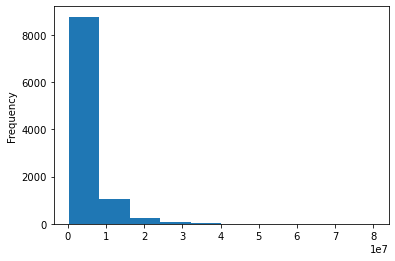

In [18]:
df['Monto'].plot.hist()

### Identificators

Most of records have same values for `Obligacion` and `Pagare`:

In [19]:
df_pagare_digit = (df
    [['Obligacion', 'Pagare']]
    .query('Pagare.str.isdigit()')
    .astype(int)
)

count_total = df.shape[0]
count_pagare_digit = df_pagare_digit.shape[0]
count_same_obligacion_pagare = df_pagare_digit.query('Obligacion == Pagare').shape[0]

(count_total, count_pagare_digit, count_same_obligacion_pagare)

(10205, 10029, 9999)

## Final schema of columns for cleaned data

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10205 entries, 0 to 10204
Data columns (total 61 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   Tipo                                 10205 non-null  category      
 1   Nro_Solicitud                        10205 non-null  int64         
 2   Obligacion                           10205 non-null  int64         
 3   Pagare                               10205 non-null  object        
 4   Homologacion Documento de Identidad  10205 non-null  object        
 5   Cod_tipoCliente                      10205 non-null  category      
 6   Nom_tipoCliente                      10205 non-null  category      
 7   Sucursal                             10205 non-null  category      
 8   Region_Cliente                       10205 non-null  category      
 9   Municipio_cliente                    10205 non-null  category      
 10  ubicacio_c

In [21]:
os.makedirs(CLEAN_DATA_PATH, exist_ok=True)

df.to_csv(f'{CLEAN_DATA_PATH}/{file_name}')